In [1]:
import numpy as np
import pandas as pd
import time
import scipy

In [2]:
@np.vectorize
def f1(x: np.ndarray) -> float:
    return 0.3 * (1 - x)


@np.vectorize
def f2(x: np.ndarray) -> float:
    return 2 * np.exp(-((x + 1.2) ** 2.5))


@np.vectorize
def f3(x: np.ndarray) -> float:
    return 7 * np.exp(-((x + 1.2) ** 3))


@np.vectorize
def f4(x: np.ndarray) -> float:
    return 40 * np.exp(-((x + 1.2) ** 4))

In [3]:
max_x = scipy.optimize.fmin(lambda x: -x * f3(x), 0)
max_x

Optimization terminated successfully.
         Current function value: -0.091023
         Iterations: 20
         Function evaluations: 40


array([0.1760625])

We define an objective function to jointly optimize the margins of product x and y assuming **product x** is the **leader** and **product y** is the **follower**
$$J_{xy} = m_x*v_x(m_x) + m_y*(v_y(m_y) + \lambda_{xy}v_x(m_x))$$
This functions conceptually assumes that $$v_y(m_y)$$ models the demand if it were sold independently
The first term maximizes the profit for product x while the second term maximizes the profit for product y while taking into account the added volumes of y caused by the selling of product x

In [4]:
def f_joint(x, y):
    l = 0.2
    return (
        (x * f2(x)) + (y * (f2(y) + f2(y) * f2(x)))
    )  # without f2(y) limiting f2(x) there woul be a degenerate case where x=0 and y=1 but with y=1 it's very hard to sell product y
    # return (x*f2(x)) + (y*(f2(y) + l*f2(x)))


def f_independent(x, y):
    return (x * f2(x)) + (y * (f2(y)))

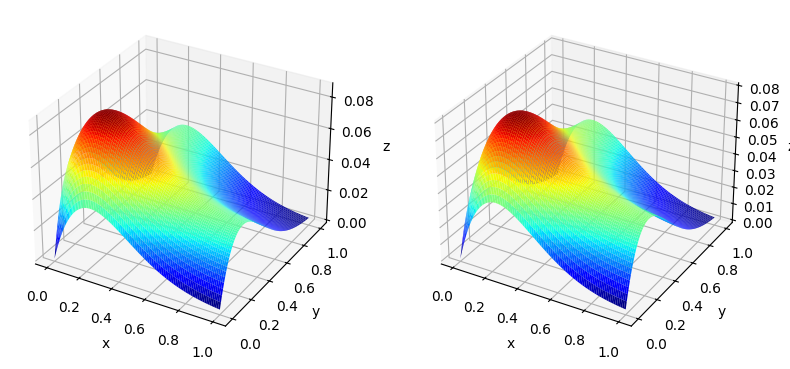

In [6]:
import matplotlib.pyplot as plt

import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection="3d")

values = np.linspace(0, 1, 100)
X, Y = np.meshgrid(values, values)
Z1 = f_joint(X, Y)

# plot a 3D surface like in the example mplot3d/surface3d_demo
ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap="jet", edgecolor="none")
ax.set_xlabel("x", fontsize=10)
ax.set_ylabel("y", fontsize=10)
ax.set_zlabel("z", fontsize=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection="3d")

# Second plot
Z2 = f_independent(X, Y)
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, cmap="jet", edgecolor="none")
ax.set_xlabel("x", fontsize=10)
ax.set_ylabel("y", fontsize=10)
ax.set_zlabel("z", fontsize=10)
plt.show()

In [7]:
matrix_joint = np.zeros((100, 100))
matrix_independent = np.zeros((100, 100))
for i, x_value in enumerate(values):
    for j, y_value in enumerate(values):
        matrix_joint[i][j] = f_joint(x_value, y_value)
        matrix_independent[i][j] = f_independent(x_value, y_value)

In [8]:
# Find the maximum value and its coordinates in the matrix
max_value_independent = np.max(matrix_independent)
max_index_independent = np.argmax(matrix_independent)
max_index_x_independent, max_index_y_independent = np.unravel_index(
    max_index_independent, matrix_independent.shape
)
max_x_independent = values[max_index_x_independent]
max_y_independent = values[max_index_y_independent]
# print(max_value_independent)
print("Margins obtained optimizing independently")
print(f"x: {max_x_independent:.2f} y: {max_y_independent:.2f}")

max_value_joint = np.max(matrix_joint)
max_index_joint = np.argmax(matrix_joint)
max_index_x_joint, max_index_y_joint = np.unravel_index(
    max_index_joint, matrix_joint.shape
)
max_x_joint = values[max_index_x_joint]
max_y_joint = values[max_index_y_joint]
print("Margins obtained with joint optimization")
print(f"x: {max_x_joint:.2f} y: {max_y_joint:.2f}")
print("Profits with margins obtained with joint optimization")
print(f"{max_value_joint:.5f}")
print("Profits with margins obtained with independent optimization")
print(f"{matrix_joint[max_index_x_independent][max_index_y_independent]:.5f}")


Margins obtained optimizing independently
x: 0.23 y: 0.23
Margins obtained with joint optimization
x: 0.20 y: 0.23
Profits with margins obtained with joint optimization
0.08708
Profits with margins obtained with independent optimization
0.08662


# Joint optimization of bivariate functions

In [ ]:
# We want to minimize the sum of functions, where the first x is the same for both functions and will be the margin of the leader

In [9]:
def bivariate_f1(x, y):
    return (x * f1(x)) + (y * (f1(y) + f1(y) * f1(x)))


def bivariate_f2(x, y):
    return (x * f2(x)) + (y * (f2(y) + f2(y) * f2(x)))


def bivariate_f3(x, y):
    return (x * f3(x)) + (y * (f3(y) + f3(y) * f3(x)))

In [10]:
def sum_f(x, y1, y2, y3):
    return bivariate_f1(x, y1) + bivariate_f2(x, y2) + bivariate_f3(x, y3)

In [11]:
def sum_f_n_vectorized(x, n: int):
    x0 = x[0]
    xi = x[1:n]
    return np.sum(bivariate_f1(x0, xi))

In [12]:
# Test the computational feasibility with 100, 200 and 500 variables
n_var_list = [100, 200, 500]
methods = ["Nelder-Mead", "Powell", "L-BFGS-B"]
# Store time and success for each method and number of variables
time_dict = {}

for n_var in n_var_list:
    print(f"Testing with {n_var} variables")
    for method in methods:
        print(f"Testing with {method} method")
        # Timestamp
        start_time = time.time()
        res = scipy.optimize.minimize(
            lambda x: -sum_f_n_vectorized(x, n_var),
            np.array([0.5] * n_var),
            bounds=[(0, 1)] * n_var,
            method=method,
        )
        end_time = time.time()
        time_dict[(n_var, method)] = [end_time - start_time, res.success]

Testing with 100 variables
Testing with Nelder-Mead method
Testing with Powell method
Testing with L-BFGS-B method
Testing with 200 variables
Testing with Nelder-Mead method
Testing with Powell method
Testing with L-BFGS-B method
Testing with 500 variables
Testing with Nelder-Mead method
Testing with Powell method
Testing with L-BFGS-B method


In [13]:
import pandas as pd

# Dataframe from dict with columns n_var, method, time
df = pd.DataFrame.from_dict(time_dict, orient="index", columns=["time", "success"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["n_var", "method"])
df.reset_index(inplace=True)
df

,n_var,method,time,success
0,100,Nelder-Mead,0.788845,False
1,100,Powell,0.034097,True
2,100,L-BFGS-B,0.007412,True
3,200,Nelder-Mead,3.039071,True
4,200,Powell,0.114460,True
5,200,L-BFGS-B,0.026008,True
6,500,Nelder-Mead,19.491852,True
7,500,Powell,0.487809,True
8,500,L-BFGS-B,0.125324,True


In [14]:
# Test the computational feasibility with 200 variables
n_var = 200
scipy.optimize.minimize(
    lambda x: -sum_f_n_vectorized(x, n_var),
    np.array([0.5] * n_var),
    bounds=[(0, 1)] * n_var,
)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -32.172703124999984
        x: [ 4.625e-01  5.000e-01 ...  5.000e-01  5.000e-01]
      nit: 1
      jac: [-7.105e-07  0.000e+00 ...  0.000e+00  0.000e+00]
     nfev: 603
     njev: 3
 hess_inv: <200x200 LbfgsInvHessProduct with dtype=float64>

In [15]:
# Test the computational feasibility with 500 variables
n_var = 500
scipy.optimize.minimize(
    lambda x: -sum_f_n_vectorized(x, n_var),
    np.array([0.5] * n_var),
    bounds=[(0, 1)] * n_var,
)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -80.67426562499998
        x: [ 4.625e-01  5.000e-01 ...  5.000e-01  5.000e-01]
      nit: 1
      jac: [-1.421e-06  0.000e+00 ...  0.000e+00  0.000e+00]
     nfev: 1503
     njev: 3
 hess_inv: <500x500 LbfgsInvHessProduct with dtype=float64>